This notebook builds on all the wonderful work on the co-visitation matrix, most recently by [@radek1](https://www.kaggle.com/radek1) [here](https://www.kaggle.com/code/radek1/co-visitation-matrix-simplified-imprvd-logic).

It produces the same result in much less time due to only a few optimizations. Apart from a more modular refactor, I've kept the original lines near the new lines so the improvements are easier to spot.

### Co-visitation Matrix
- There exist products that are frequently viewed and bought together. Here we leverage this idea by computing a co-visitation matrix of products.

1. First we look at all pairs of events within the same session that are close to each other in time (< 1 day). We compute co-visitation matrix  Maid1,aid2 by counting global number of event pairs for each pair across all sessions.
2. For each  aid1,   we find top 20 most frequent aid2: aid2=argsort(M[aid])[-20:]
3. We produce test results by concatenating tail(20) of test session events (see https://www.kaggle.com/code/simamumu/old-test-data-last-20-aid-get-lb0-947) with the most likely recommendations from co-visitation matrix. These recommendations are generated from session AIDs and aid2 from the step 2

In [1]:
import pandas as pd
import numpy as np

train = pd.read_parquet('../input/otto-full-optimized-memory-footprint/train.parquet')
test = pd.read_parquet('../input/otto-full-optimized-memory-footprint/test.parquet')

!pip install pickle5
import pickle5 as pickle

with open('../input/otto-full-optimized-memory-footprint/id2type.pkl', "rb") as fh:
    id2type = pickle.load(fh)
with open('../input/otto-full-optimized-memory-footprint/type2id.pkl', "rb") as fh:
    type2id = pickle.load(fh)
    
sample_sub = pd.read_csv('../input/otto-recommender-system/sample_submission.csv')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.4/256.4 kB 549.9 kB/s eta 0:00:00


In [2]:
fraction_of_sessions_to_use = 0.5

Just a bit more of memory footprint optimization. We will be pushing the Kaggle VM to the limit in this notebook!

In [3]:
train.session = train.session.astype(np.int32)
train.aid = train.aid.astype(np.int32)
train.ts /= 1000
train.ts = train.ts.astype(np.int32)

In [4]:
train.head()

,session,aid,ts,type
0,0,1517085,1659304,0
1,0,1563459,1659304,0
2,0,1309446,1659367,0
3,0,16246,1659367,0
4,0,1781822,1659367,0


In [5]:
%%time

lucky_sessions_train = train.drop_duplicates(['session']).sample(frac=fraction_of_sessions_to_use)['session']
subset_of_train = train[train.session.isin(lucky_sessions_train)]

lucky_sessions_test = test.drop_duplicates(['session']).sample(frac=fraction_of_sessions_to_use)['session']
subset_of_test = test[test.session.isin(lucky_sessions_test)]

del train

CPU times: user 16 s, sys: 4.33 s, total: 20.4 s
Wall time: 20.4 s


In [6]:
subset_of_train.index = pd.MultiIndex.from_frame(subset_of_train[['session']])
subset_of_test.index = pd.MultiIndex.from_frame(subset_of_test[['session']])

In [7]:
from collections import defaultdict, Counter
from tqdm import tqdm

next_AIDs = defaultdict(Counter)


def update_covisitation_counter(train_or_test, chunk_size=30_000):
    sessions = train_or_test.session.unique()
    
    # Loop through chunks of sessions
    for i in tqdm(range(0, sessions.shape[0], chunk_size)):
        # Get current chunk of sessions
        consecutive_AIDs = train_or_test.loc[sessions[i]:sessions[min(sessions.shape[0]-1, i+chunk_size-1)]].reset_index(drop=True)

        # Get the 30 most recent products per session
        # consecutive_AIDs = consecutive_AIDs.groupby('session').apply(lambda g: g.tail(30)).reset_index(drop=True)
        consecutive_AIDs = consecutive_AIDs.groupby('session', as_index=False).nth(list(range(-30,0))).reset_index(drop=True)

        # Merge sessions onto themselves so we can find pairs of products that are actioned on together
        consecutive_AIDs = consecutive_AIDs.merge(consecutive_AIDs, on='session')

        # Remove entries that are themselves
        consecutive_AIDs = consecutive_AIDs[consecutive_AIDs.aid_x != consecutive_AIDs.aid_y]

        # Calculate how many days between products
        consecutive_AIDs['days_elapsed'] = (consecutive_AIDs.ts_y - consecutive_AIDs.ts_x) / (24 * 60 * 60)

        # Only keep products that are within a day of each other
        consecutive_AIDs = consecutive_AIDs[(consecutive_AIDs.days_elapsed > 0) & (consecutive_AIDs.days_elapsed <= 1)]

        # Iterate through all sessions and count pairs of co-visited products
        # for row in consecutive_AIDs.drop_duplicates(['session', 'aid_x', 'aid_y']).itertuples():
        #     next_AIDs[row.aid_x][row.aid_y] += 1
        consecutive_AIDs.drop_duplicates(['session', 'aid_x', 'aid_y'], inplace=True)
        for aid_x, aid_y in zip(consecutive_AIDs['aid_x'], consecutive_AIDs['aid_y']):
            next_AIDs[aid_x][aid_y] += 1
        

update_covisitation_counter(subset_of_train)
update_covisitation_counter(subset_of_test)

100%|██████████| 28/28 [00:16<00:00,  1.75it/s]


In [8]:
len(next_AIDs)

1669296

Now let's generate the predictions.

In [9]:
%%time

test_session_AIDs = test.groupby('session')['aid'].apply(list)
session_types = ['clicks', 'carts', 'orders']

test_session_AIDs.head()

CPU times: user 1min 6s, sys: 601 ms, total: 1min 7s
Wall time: 1min 7s


session
12899779                                              [59625]
12899780           [1142000, 582732, 973453, 736515, 1142000]
12899781    [141736, 199008, 57315, 194067, 199008, 199008...
12899782    [1669402, 1494780, 1494780, 1494780, 1494780, ...
12899783    [255297, 1114789, 255297, 300127, 198385, 3001...
Name: aid, dtype: object

In [10]:
labels = []

# Loop through all test session product IDs (AIDs)
for AIDs in tqdm(test_session_AIDs):
    # Reverse the set of AIDs
    AIDs = list(dict.fromkeys(AIDs[::-1]))

    # Take the most recent 20 if there are more than 20
    if len(AIDs) >= 20:
        labels.append(AIDs[:20])

    # Otherwise, get the most likely products to see next to fill up to the 20th spot
    else:
        # counter = Counter()
        # for AID in AIDs:
        #     subsequent_AID_counter = next_AIDs.get(AID)
        #     if subsequent_AID_counter:
        #         counter += subsequent_AID_counter
        counter = Counter()
        for AID in AIDs:
            counter.update(next_AIDs.get(AID, {}))
        
        AIDs += [AID for AID, cnt in counter.most_common(40) if AID not in AIDs]

        labels.append(AIDs[:20])

100%|██████████| 1671803/1671803 [1:27:35<00:00, 318.12it/s]


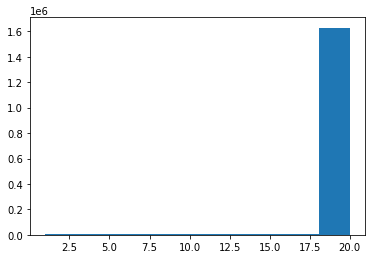

In [11]:
from matplotlib import pyplot as plt

plt.hist([len(l) for l in labels]);

In [12]:
labels_as_strings = [' '.join([str(l) for l in lls]) for lls in labels]

predictions = pd.DataFrame(data={'session_type': test_session_AIDs.index, 'labels': labels_as_strings})

In [13]:
prediction_dfs = []

for st in session_types:
    modified_predictions = predictions.copy()
    modified_predictions.session_type = modified_predictions.session_type.astype('str') + f'_{st}'
    prediction_dfs.append(modified_predictions)

submission = pd.concat(prediction_dfs).reset_index(drop=True)

In [14]:
submission.head()

,session_type,labels
0,12899779_clicks,59625 499621 469285 386310 514164 1770962 1354...
1,12899780_clicks,1142000 736515 973453 582732 1502122 487136 88...
2,12899781_clicks,918667 199008 194067 57315 141736 1460571 8113...
3,12899782_clicks,1007613 595994 1033148 834354 479970 1696036 8...
4,12899783_clicks,1817895 607638 1754419 1216820 1729553 300127 ...


In [15]:
submission.to_csv('submission.csv', index=False)